# FLFS - Spot-variation FFS with lifetime and orbital scanning

Load a data file with TCSPC data for each detector element of freely diffusing 20 nm fluorescent beads. Use the microtimes to generate filter functions that can descriminate between fluorescence (exponential decay) and dark counts (uniform distribution). Calculate the autocorrelations for spot-variation FCS for both the unfiltered and filtered data. Since the measurement was done with circular scanning FFS, the fit is calibration-free (w0 is a fit parameter).

Data taken with a 5x5 array detector but only 20 channels were connected to the TCSPC module. The other 5 channels contain some dummy photons.

Import packages

In [1]:
from brighteyes_ffs.fcs.atimes_data import load_atimes_data
from brighteyes_ffs.fcs.atimes2corrparallel import atimes_2_corrs_parallel as correlate
from brighteyes_ffs.fcs.plot_fingerprint import plot_fingerprint5x5
from brighteyes_ffs.fcs.align_lifetime_hist import align_hist
from brighteyes_ffs.fcs.filter_ap import filter_range, filter_ap
from brighteyes_ffs.fcs.arrivaltimes2filteredtimetrace import atimes_filtered
from brighteyes_ffs.fcs.get_fcs_info import get_metafile_from_file, get_file_info
from brighteyes_ffs.fcs.fcs_fit import fcs_fit, make_fit_info_global_fit, read_global_fit_result

from brighteyes_ffs.tools.fit_curve import fit_curve
from brighteyes_ffs.tools.find_nearest import find_nearest
from brighteyes_ffs.tools.stokes_einstein import stokes_einstein

import matplotlib.pyplot as plt
import numpy as np

File name with raw data and file name with metadata. Typically, these are the same and you can directly call mdata=get_file_info(file). If not, first call get_metafile_from_file, which checks for the file with the corresponding metadata.

In [2]:
file = "C:/Users/eslenders/OneDrive - Fondazione Istituto Italiano Tecnologia/SPAD-FCS/Manuscript_python_code/Zenodo/raw_data/ffs/20210325_03_np20nm_cooled15_lp60_224s_v2.h5"
mdata = get_file_info(get_metafile_from_file(file))

## Load data and calculate time trace

In [3]:
n_ch = 25
raw_data=load_atimes_data(file, channels=n_ch, perform_calib=False)
raw_data.macrotime = 1e-12
raw_data.microtime = 1e-12
maxseg = 1000 # number of time points for plotting the intensity trace
time_trace = np.zeros((maxseg, n_ch))

time = getattr(raw_data, "det12")[:,0]
timeAbs = time * raw_data.macrotime
time_bins = np.linspace(0, np.max(timeAbs), maxseg + 1)

for det in range(n_ch):
    time = getattr(raw_data, "det"+str(det))[:,0]
    timeAbs = time * raw_data.macrotime
    [Itrace, timeBins] = np.histogram(timeAbs, time_bins)
    time_trace[:, det] = Itrace[0:] #/ (timeBins[2] - timeBins[1]) / 1e3

Plot time trace

Text(0, 0.5, 'Photon count rate (kHz)')

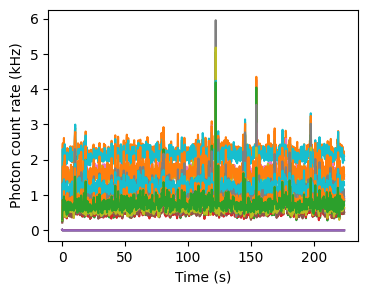

In [4]:
fig = plt.figure(figsize=(4,3))
for i in range(n_ch):
    plt.plot(timeBins[:-1], time_trace[:,i] / (timeBins[2] - timeBins[1]) / 1e3)
ymin = np.min(time_trace)
ymax = np.max(time_trace)
plt.xlabel('Time (s)')
plt.ylabel('Photon count rate (kHz)')

## Calculate microtime histograms

In [5]:
n_bins = 576 # number of microtime bins
laser_freq = 40e6 # laser frequency (Hz)

for det in range(n_ch):
    macrotime = getattr(raw_data, "det" + str(det))[:,0] # ps
    microtime = getattr(raw_data, "det" + str(det))[:,1]
    microtime = np.mod(microtime, 1e12 / laser_freq)
    microtime = -microtime + np.max(microtime)
    [Ihist, lifetime_bins] = np.histogram(microtime, n_bins)
    lifetime_bins = lifetime_bins[0:-1] * raw_data.microtime * 1e12
    setattr(raw_data, "hist" + str(det), np.transpose(np.stack((lifetime_bins, Ihist))))
    setattr(raw_data, "det" + str(det), np.transpose([macrotime, microtime]))
    lifetime_bins_N = (lifetime_bins - lifetime_bins[0]) / lifetime_bins[1]

In [6]:
align_hist(raw_data)

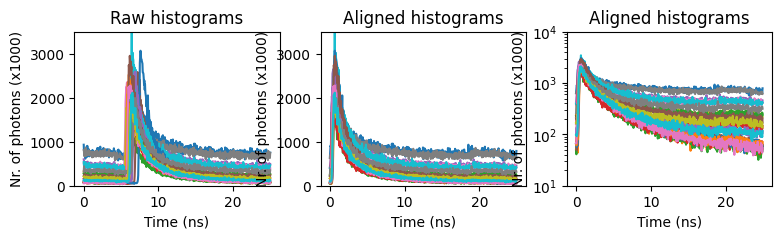

In [7]:
plot_channels = [i for i in range(n_ch) if i not in [0, 4, 20, 23, 24]]
f, axs = plt.subplots(1, 3, figsize=(9,2))

for det in plot_channels:
    hist = getattr(raw_data, "hist" + str(det))
    axs[0].plot(1e-3*hist[:,0], hist[:,1])
axs[0].set_title('Raw histograms')

for det in plot_channels:
    histD = getattr(raw_data, "Ahist" + str(det))    
    axs[1].plot(1e-3*histD[:,0], histD[:,1])
    axs[2].plot(1e-3*histD[:,0], histD[:,1])

for i in range(3):
    axs[i].set_xlabel("Time (ns)")
    axs[i].set_ylabel("Nr. of photons (x1000)")  # of 43.4 ps
    axs[i].set_ylim([0, 3500])
axs[1].set_title('Aligned histograms')
axs[2].set_title('Aligned histograms')
axs[2].set_ylim([10, 1e4])
axs[2].set_yscale('log')

## Calculate filter functions to remove dark counts

### Select only reasonable portion of histograms for filtering

In [8]:
filter_range(raw_data) # find start value index of the decay
raw_data.fit_range[:,1] = raw_data.fit_range[:,0] + 260 # set stop index at a fixed length after start

Text(0.5, 1.0, 'Grey microtimes excluded from further analysis')

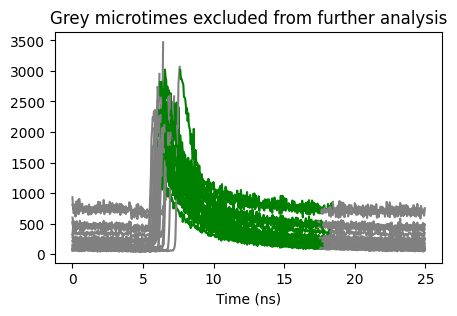

In [9]:
f, axs = plt.subplots(1, 1, figsize=(5,3))

fitrange = raw_data.fit_range
for det in plot_channels:
    fitr = fitrange[det]
    hist = getattr(raw_data, "hist" + str(det))
    axs.plot(1e-3*hist[0:fitr[0],0], hist[0:fitr[0],1], 'grey')
    axs.plot(1e-3*hist[fitr[0]:fitr[1],0], hist[fitr[0]:fitr[1],1], 'g')
    axs.plot(1e-3*hist[fitr[1]:,0], hist[fitr[1]:,1], 'grey')
axs.set_xlabel('Time (ns)')
axs.set_title('Grey microtimes excluded from further analysis')

### Fit exponential

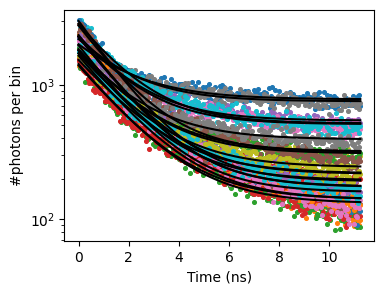

In [10]:
fitresults = np.zeros((n_ch, 4))

plt.figure(figsize=(4,3))
for det in range(n_ch):
    if det not in [0, 4, 20, 23, 24]:
        # get histogram detector element i
        [idxStart, idxStop] = raw_data.fit_range[det, :]
        fitRangeL = idxStop - idxStart
        
        Ihist_single = getattr(raw_data, "hist" + str(det)) # number of photons per bin of 43.4 ps as a function of time in ps
        Ihist = Ihist_single[idxStart:idxStop, 1]
        lifetime_bins = Ihist_single[0:fitRangeL, 0]

        plt.scatter(1e-3*lifetime_bins, Ihist, s=7)
        plt.xlabel("Time (ns)")
        plt.ylabel("#photons per bin")

        # fit exponential
        fitresult = fit_curve(Ihist, lifetime_bins, 'exp', np.asarray([1, 1, 1, 1]), np.asarray([60000, 0.5, 10, 0]), np.asarray([0, 0, -1e4,-1e4]), np.asarray([1e6, 20, 1e6,1e6]))
        A      = fitresult.x[0]
        alpha  = fitresult.x[1]
        B     = fitresult.x[2]
        dx      = fitresult.x[3]
        plt.plot(1e-3*lifetime_bins, A * np.exp(-alpha * (lifetime_bins-dx)) + B, color='k')
        plt.yscale('log')

        fitresults[det, :] = [A, alpha, B, dx]

In [12]:
mean_val = 1e-3 * np.mean(1 / fitresults[plot_channels, 1])
std_val  = 1e-3 * np.std(1 / fitresults[plot_channels, 1])

print(f"average lifetime: {mean_val:.2f} ± {std_val:.2f} ns")

average lifetime: 1.77 ± 0.09 ns


### Calculate filter functions

In [18]:
filters_theo = np.zeros((n_ch, len(hist), 2))
for det in range(n_ch):
    if det not in [0, 4, 20, 23, 24]:
        # calculate filter 
        tau = 1 / fitresults[det, 1] / lifetime_bins[1] # tau in dim.less units of bin time
        A = fitresults[det, 0]
        B = fitresults[det, 2]
        T = int(np.diff(raw_data.fit_range[det, :])[0])
        offset = B / A # relative offset, wrt amplitude
        
        # calculate filter
        Ftheo = filter_ap(0, tau, T, offset, norm_exp=False, plot_fig=False)
        # microtimes outside filter set to 0
        [startIdx, stopIdx] = raw_data.fit_range[det, :]
        filters_theo[det, startIdx:stopIdx, :] = np.transpose(Ftheo)

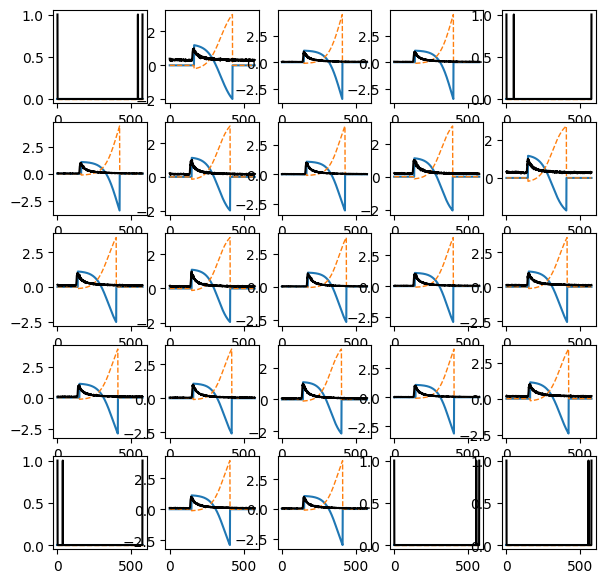

In [19]:
f, axs = plt.subplots(5, 5, figsize=(7,7))

for det in range(n_ch):
    Ihist_single = getattr(raw_data, "hist" + str(det))
    j = np.mod(det, 5)
    i = det // 5
    axs[i, j].plot(filters_theo[det, :, 0])
    axs[i, j].plot(filters_theo[det, :, 1], linestyle='--', linewidth=1.0)
    axs[i, j].plot(Ihist_single[:,1]/np.max(Ihist_single[:,1]), color='black')

### Apply filter weights to all photons based on microtimes

In [22]:
raw_data.microbintime = 1e-12*lifetime_bins[1] # s
atimes_filtered(raw_data, filters_theo, micro_bin=False, verbose=False)

## Calculate correlations with and without filters

In [23]:
list_of_g = ['central', 'sum3', 'sum5']
list_of_g_out = ['central', 'sum3', 'sum5']
averaging = None
resolution = 25
chunksize = 1

In [24]:
G = correlate(raw_data, list_of_g, accuracy=resolution, split=chunksize, averaging=averaging, list_of_g_out=list_of_g_out)

Calculating correlation central
Extracting and sorting photons
   Filter 0
   Filter 1
   Filter 2
Calculating correlation sum3
Extracting and sorting photons
   Filter 0
   Filter 1
   Filter 2
Calculating correlation sum5
Extracting and sorting photons
   Filter 0
   Filter 1
   Filter 2
Calculating average correlations


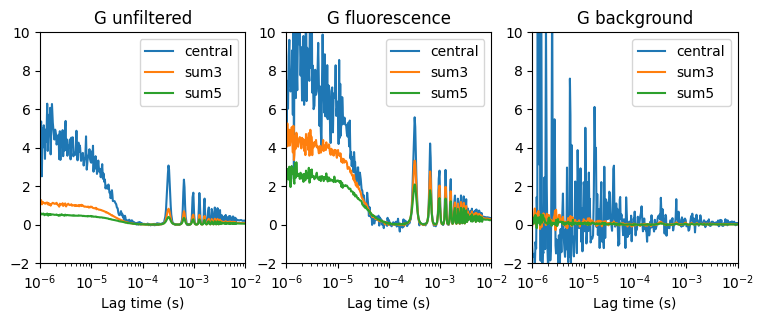

<Figure size 640x480 with 0 Axes>

In [18]:
titles = ['G unfiltered', 'G fluorescence', 'G background']
f, axs = plt.subplots(1, 3, figsize=(9,3))
plt.figure()
for i, corr in enumerate(list_of_g_out):
    Gsingle = getattr(G, corr + '_average')
    axs[0].plot(Gsingle[:,0], Gsingle[:,1], label=corr)
    Gsingle = getattr(G, corr + 'F1_average')
    axs[1].plot(Gsingle[:,0], Gsingle[:,1], label=corr)
    Gsingle = getattr(G, corr + 'F2_average')
    axs[2].plot(Gsingle[:,0], Gsingle[:,1], label=corr)
    
    axs[i].set_xscale('log')
    axs[i].set_xlim([1e-6, 1e-2])
    axs[i].set_ylim([-2, 10])
    axs[i].set_xlabel('Lag time (s)')
    axs[i].set_title(titles[i])

for i in range(3):
    axs[i].legend()

## Fit correlations  
Fit correlations from both unfiltered and filtered data

In [32]:
SF = [4.5, 4.1, 4.1] # shape parameter for central, sum3x3, sum5x5
amp = [0.1, 1, 1] # start values for the amplitude of the correlation functions for central, sum3x3, sum5x5
w0 = [220e-9, 290e-9, 340e-9] # w0 for central, sum3, sum5
fit_range = [1e-6, 5e-3] # fit range in s

fitresultsraw = []
Glist = ["central", "sum3", "sum5", "centralF1", "sum3F1", "sum5F1"]
fitarray = np.array([1, 1, 1, 0, 0, 0, 0]) # Fit N, tauD, w0. Keep SF, radius, period and offset fixed.
fitresults = np.zeros((len(Glist), len(fitarray))) # store fitted values here

for k in range(len(Glist)):
    
    # get avereage correlation
    Gexp, tau = G.get_av_corrs([Glist[k]], av='_average')
    Gexp = np.squeeze(Gexp)
    
    # fit settings
    [dummy, start] = find_nearest(tau,fit_range[0])
    [dummy, stop] = find_nearest(tau,fit_range[1])
    paramStart = np.array([amp[np.mod(k, 3)], 2.4, 300e-9, SF[np.mod(k, 3)], 0.5e-6, 320e-6, 0]) #  [N, tauD, w, SF, Rcirc, Tcirc, offset]
    paramMin = np.array([0, 5e-6, 100e-9, 3, 0, 0, -1])
    paramMax = np.array([1e6, 10, 10000e-9, 6, 10, 10, 1])

    # perform fit
    fitresult = fcs_fit(Gexp[start:stop],  tau[start:stop], 'fitfun_circfcs', fitarray, paramStart, paramMin, paramMax, plotInfo=-1)
    fitresultsraw.append(fitresult)
    fitresults[k, :] = fitresult.x

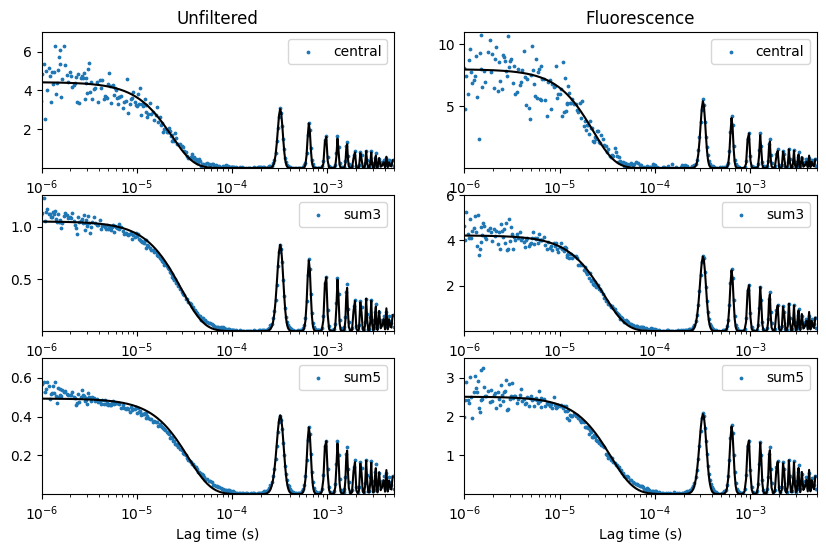

<Figure size 640x480 with 0 Axes>

In [33]:
f, axs = plt.subplots(3, 2, figsize=(10,6))
plt.figure()
for i, corr in enumerate(list_of_g_out):
    fitresult_single = fitresultsraw[i]
    Gsingle = getattr(G, corr + '_average')
    axs[i][0].scatter(Gsingle[:,0], Gsingle[:,1], label=corr, s=3)
    axs[i][0].plot(Gsingle[start:stop,0], Gsingle[start:stop,1]-fitresult_single.fun, 'k')
    
    fitresult_single = fitresultsraw[i+3]
    Gsingle = getattr(G, corr + 'F1_average')
    axs[i][1].scatter(Gsingle[:,0], Gsingle[:,1], label=corr, s=3)
    axs[i][1].plot(Gsingle[start:stop,0], Gsingle[start:stop,1]-fitresult_single.fun, 'k')

ylim = [[7, 1.3, 0.7], [11, 6, 3.5]]
titles = ['Unfiltered', 'Fluorescence']
    
for i in range(3):
    for j in range(2):
        axs[i][j].set_xscale('log')
        axs[i][j].set_xlim([1e-6, 5e-3])
        axs[i][j].set_ylim([1e-3, ylim[j][i]])
        axs[i][j].legend()
        axs[2][j].set_xlabel('Lag time (s)')
        axs[0][j].set_title(titles[j])

Diffusion coefficient:
D = 19.45 um^2/s --> diameter: 22.07 nm (unfiltered)
D = 20.19 um^2/s --> diameter: 21.26 nm (filtered)

Concentration:
c = 16.46 /um^3 (unfiltered, not correct because not passing through origin)
c = 2.41 /um^3 (filtered)


Text(0, 0.5, 'N')

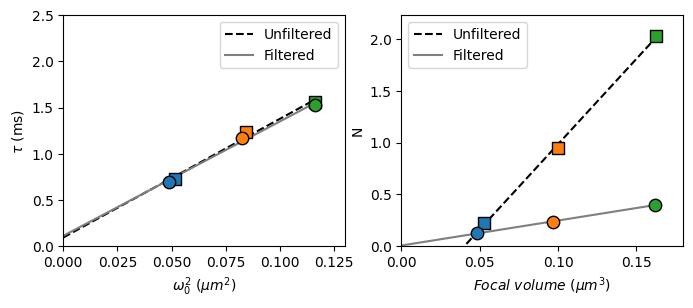

In [29]:
f, axs = plt.subplots(1, 2, figsize=(8,3))

# -------------------- Diffusion time --------------------

# Unfiltered
w2 = 1e12*fitresults[0:3,2]**2 # um^2/s
linfit = np.polyfit(w2, fitresults[0:3,1], 1)
xfit = np.array([0, np.max(w2)])
yfit = linfit[0] * xfit + linfit[1]

D = 1e3 / 4 / linfit[0]
print('Diffusion coefficient:')
print(f"D = {D:.2f} um^2/s --> diameter: {1e9*stokes_einstein(1e-12 * D):.2f} nm (unfiltered)")

axs[0].plot(xfit, yfit, '--', color='k', label='Unfiltered', zorder=1)
for i in range(3):
    axs[0].scatter(w2[i], fitresults[i,1], marker='s', color='C'+str(i), edgecolors='k', s=80, zorder=2)

# Filtered
w2F = 1e12*fitresults[3:6,2]**2
linfit = np.polyfit(w2F, fitresults[3:6,1], 1)
xfit = np.array([0, np.max(w2F)])
yfit = linfit[0] * xfit + linfit[1]

D = 1e3 / 4 / linfit[0]
print(f"D = {D:.2f} um^2/s --> diameter: {1e9*stokes_einstein(1e-12 * D):.2f} nm (filtered)")

axs[0].plot(xfit, yfit, '-', color='C7', label='Filtered', zorder=1)
for i in range(3):
    axs[0].scatter(w2F[i], fitresults[i+3,1], color='C'+str(i), s=80, edgecolors='k', zorder=2)
    
axs[0].axis([0, 0.13, 0, 2.5])
axs[0].set_xlabel(r'$\omega_0^2$ $(µm^2)$')
axs[0].set_ylabel(r'$\tau$ (ms)')
axs[0].legend()


# -------------------- N --------------------

# Unfiltered
vol = 1e18 * fitresults[0:3,2]**3 * SF
for i in range(3):
    axs[1].scatter(vol[i], fitresults[i,0], marker='s', color='C'+str(i), edgecolors='k', s=80, zorder=2)

linfit = np.polyfit(vol, fitresults[0:3,0], 1)
xfit = np.array([0, np.max(vol)])
yfit = linfit[0] * xfit + linfit[1]

c = linfit[0]
print()
print('Concentration:')
print(f"c = {c:.2f} /um^3 (unfiltered, not correct because not passing through origin)")

axs[1].plot(xfit, yfit, '--', color='k', label='Unfiltered', zorder=1)

# filtered
volF = 1e18 * fitresults[3:6,2]**3 * SF
for i in range(3):
    axs[1].scatter(volF[i], fitresults[i+3,0], color="C"+str(i), s=80, edgecolors='k', zorder=2)

linfit = np.polyfit(volF, fitresults[3:6,0], 1)
xfit = np.array([0, np.max(volF)])
yfit = linfit[0] * xfit + linfit[1]

c = linfit[0]
print(f"c = {c:.2f} /um^3 (filtered)")

axs[1].plot(xfit, yfit, '-', color='C7', label='Filtered', zorder=1)
axs[1].legend()

axs[1].axis([0, 0.18, 0, np.max(fitresults[:,0])*1.1])
axs[1].set_xlabel(r'$Focal$ $volume$ $(µm^3)$')
axs[1].set_ylabel('N')